<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Hyperparameter Tuning

## *Data Science Unit 4 Sprint 2 Assignment 4*

## Your Mission, should you choose to accept it...

To hyperparameter tune and extract every ounce of accuracy out of this telecom customer churn dataset: [Available Here](https://lambdaschool-data-science.s3.amazonaws.com/telco-churn/WA_Fn-UseC_-Telco-Customer-Churn+(1).csv)

## Requirements

- Load the data
- Clean the data if necessary (it will be)
- Create and fit a baseline Keras MLP model to the data.
- Hyperparameter tune (at least) the following parameters:
 - batch_size
 - training epochs
 - optimizer
 - learning rate (if applicable to optimizer)
 - momentum (if applicable to optimizer)
 - activation functions
 - network weight initialization
 - dropout regularization
 - number of neurons in the hidden layer
 
 You must use Grid Search and Cross Validation for your initial pass of the above hyperparameters
 
 Try and get the maximum accuracy possible out of this data! You'll save big telecoms millions! Doesn't that sound great?


In [1]:
##### Your Code Here #####

### Load the data
import pandas as pd

PATH = "/content/WA_Fn-UseC_-Telco-Customer-Churn+(1).csv"
df = pd.read_csv(PATH)
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Examine and Clean the Data

In [2]:
### Examine the data

df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [54]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [4]:
df.describe(exclude='number')

# Total charges not a number? 
# Customer ID has high cardinality

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,6266-QHOJZ,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,20.2,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


In [19]:
# df['TotalCharges'] = df['TotalCharges'].replace(" ","")
# df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

# df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [21]:
df.describe(exclude='number')

# Partner, Dependents, PhoneService, PaperlessBilling, Churn can be turned into
# binary

# One hot encode rest of categorical values to avoid false ranking being added
# to columns like PaymentType, gender, etc

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,6266-QHOJZ,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


In [4]:
!pip install category_encoders
import category_encoders as ce

     |████████████████████████████████| 81kB 2.5MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
## Define function to wrangle data:

# Turn Partner, Dependents, PhoneService, PaperlessBilling, Churn into binary
# Get TotalCharges into appropriate data type
# Drop customerID column
# One Hot Encode remaining categorical features

def wrangle(x):
  """Wrangle telecomm data for use with NN model"""
  # Convert columns to binary output:
  # Churn
  churns = []
  for row in x['Churn']:
    if row == 'No':
      row = 0
    else:
      row = 1
    churns.append(row)
  x['Churn'] = churns

  # Partner
  partners = []
  for row in x['Partner']:
    if row == 'No':
      row = 0
    else:
      row = 1
    partners.append(row)
  x['Partner'] = partners

  # Dependents
  deps = []
  for row in x['Dependents']:
    if row == 'No':
      row = 0
    else:
      row = 1
    deps.append(row)
  x['Dependents'] = deps

  # PhoneService
  ps = []
  for row in x['PhoneService']:
    if row == 'No':
      row = 0
    else:
      row = 1
    ps.append(row)
  x['PhoneService'] = ps

  # PaperlessBilling
  paperless = []
  for row in x['PaperlessBilling']:
    if row == 'No':
      row = 0
    else:
      row = 1
    paperless.append(row)
  x['PaperlessBilling'] = paperless

  # Drop customerID - unique identifier, high cardinality:
  x = x.drop('customerID', axis=1)

  # Convert TotalCharges dtype:
  x['TotalCharges'] = x['TotalCharges'].replace(" ","")
  x['TotalCharges'] = pd.to_numeric(x['TotalCharges'])

  # Encode remaining categorical features:
  encoder = ce.OneHotEncoder()
  encoder.fit(x)
  x = encoder.transform(x)

  return x

In [6]:
tele = df.copy()

tele = wrangle(tele)

print(tele.shape)
tele.head()

(7043, 42)


,gender_1,gender_2,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines_1,MultipleLines_2,MultipleLines_3,InternetService_1,InternetService_2,InternetService_3,OnlineSecurity_1,OnlineSecurity_2,OnlineSecurity_3,OnlineBackup_1,OnlineBackup_2,OnlineBackup_3,DeviceProtection_1,DeviceProtection_2,DeviceProtection_3,TechSupport_1,TechSupport_2,TechSupport_3,StreamingTV_1,StreamingTV_2,StreamingTV_3,StreamingMovies_1,StreamingMovies_2,StreamingMovies_3,Contract_1,Contract_2,Contract_3,PaperlessBilling,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,PaymentMethod_4,MonthlyCharges,TotalCharges,Churn
0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,29.85,29.85,0
1,0,1,0,0,0,34,1,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,56.95,1889.50,0
2,0,1,0,0,0,2,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,53.85,108.15,1
3,0,1,0,0,0,45,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,42.30,1840.75,0
4,1,0,0,0,0,2,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,70.70,151.65,1


In [7]:
tele.dtypes

gender_1                int64
gender_2                int64
SeniorCitizen           int64
Partner                 int64
Dependents              int64
tenure                  int64
PhoneService            int64
MultipleLines_1         int64
MultipleLines_2         int64
MultipleLines_3         int64
InternetService_1       int64
InternetService_2       int64
InternetService_3       int64
OnlineSecurity_1        int64
OnlineSecurity_2        int64
OnlineSecurity_3        int64
OnlineBackup_1          int64
OnlineBackup_2          int64
OnlineBackup_3          int64
DeviceProtection_1      int64
DeviceProtection_2      int64
DeviceProtection_3      int64
TechSupport_1           int64
TechSupport_2           int64
TechSupport_3           int64
StreamingTV_1           int64
StreamingTV_2           int64
StreamingTV_3           int64
StreamingMovies_1       int64
StreamingMovies_2       int64
StreamingMovies_3       int64
Contract_1              int64
Contract_2              int64
Contract_3

### Normalize the data

In [0]:
data = tele.copy()

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Preserve churn feature to retain pure binary values
labels = data['Churn']
data_scaled = scaler.fit_transform(data.drop('Churn', axis=1))

# Convert to dataframe for readability

data_df = pd.DataFrame(data_scaled, 
                       columns=data.drop('Churn', axis=1).columns)
data_df['Churn'] = labels
print(data_df.shape)
data_df.head()

(7043, 42)


,gender_1,gender_2,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines_1,MultipleLines_2,MultipleLines_3,InternetService_1,InternetService_2,InternetService_3,OnlineSecurity_1,OnlineSecurity_2,OnlineSecurity_3,OnlineBackup_1,OnlineBackup_2,OnlineBackup_3,DeviceProtection_1,DeviceProtection_2,DeviceProtection_3,TechSupport_1,TechSupport_2,TechSupport_3,StreamingTV_1,StreamingTV_2,StreamingTV_3,StreamingMovies_1,StreamingMovies_2,StreamingMovies_3,Contract_1,Contract_2,Contract_3,PaperlessBilling,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,PaymentMethod_4,MonthlyCharges,TotalCharges,Churn
0,1.009559,-1.009559,-0.439916,1.034530,-0.654012,-1.277445,-3.054010,3.054010,-0.963330,-0.854176,1.381712,-0.885660,-0.525927,1.006696,-0.633933,-0.525927,1.378241,-0.883620,-0.525927,1.129427,-0.723968,-0.525927,1.013869,-0.639439,-0.525927,1.227357,-0.790132,-0.525927,1.236489,-0.79607,-0.525927,0.904184,-0.514249,-0.562975,0.829798,1.406418,-0.544807,-0.529885,-0.525047,-1.160323,-0.994194,0
1,-0.990532,0.990532,-0.439916,-0.966622,-0.654012,0.066327,0.327438,-0.327438,1.038066,-0.854176,1.381712,-0.885660,-0.525927,-0.993349,1.577454,-0.525927,-0.725563,1.131709,-0.525927,-0.885405,1.381277,-0.525927,1.013869,-0.639439,-0.525927,1.227357,-0.790132,-0.525927,1.236489,-0.79607,-0.525927,-1.105970,1.944582,-0.562975,-1.205113,-0.711026,1.835513,-0.529885,-0.525047,-0.259629,-0.173740,0
2,-0.990532,0.990532,-0.439916,-0.966622,-0.654012,-1.236724,0.327438,-0.327438,1.038066,-0.854176,1.381712,-0.885660,-0.525927,-0.993349,1.577454,-0.525927,1.378241,-0.883620,-0.525927,1.129427,-0.723968,-0.525927,1.013869,-0.639439,-0.525927,1.227357,-0.790132,-0.525927,1.236489,-0.79607,-0.525927,0.904184,-0.514249,-0.562975,0.829798,-0.711026,1.835513,-0.529885,-0.525047,-0.362660,-0.959649,1
3,-0.990532,0.990532,-0.439916,-0.966622,-0.654012,0.514251,-3.054010,3.054010,-0.963330,-0.854176,1.381712,-0.885660,-0.525927,-0.993349,1.577454,-0.525927,-0.725563,1.131709,-0.525927,-0.885405,1.381277,-0.525927,-0.986321,1.563872,-0.525927,1.227357,-0.790132,-0.525927,1.236489,-0.79607,-0.525927,-1.105970,1.944582,-0.562975,-1.205113,-0.711026,-0.544807,1.887201,-0.525047,-0.746535,-0.195248,0
4,1.009559,-1.009559,-0.439916,-0.966622,-0.654012,-1.236724,0.327438,-0.327438,1.038066,-0.854176,-0.723740,1.129102,-0.525927,1.006696,-0.633933,-0.525927,-0.725563,1.131709,-0.525927,1.129427,-0.723968,-0.525927,1.013869,-0.639439,-0.525927,1.227357,-0.790132,-0.525927,1.236489,-0.79607,-0.525927,0.904184,-0.514249,-0.562975,0.829798,1.406418,-0.544807,-0.529885,-0.525047,0.197365,-0.940457,1


### Split into train and test sets

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_df, 
                               train_size=0.70, 
                               test_size=0.30,
                               stratify = data_df['Churn'])

print(train.shape, test.shape)

(4930, 42) (2113, 42)


In [11]:
# Define X feature matrices and y target vectors

target = 'Churn'

X_train = train.drop(target, axis=1)
X_test = test.drop(target, axis=1)

y_train = train[target]
y_test = test[target]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4930, 41)
X_test shape: (2113, 41)
y_train shape: (4930,)
y_test shape: (2113,)


In [12]:
# Sanity Check

X_train.head()

,gender_1,gender_2,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines_1,MultipleLines_2,MultipleLines_3,InternetService_1,InternetService_2,InternetService_3,OnlineSecurity_1,OnlineSecurity_2,OnlineSecurity_3,OnlineBackup_1,OnlineBackup_2,OnlineBackup_3,DeviceProtection_1,DeviceProtection_2,DeviceProtection_3,TechSupport_1,TechSupport_2,TechSupport_3,StreamingTV_1,StreamingTV_2,StreamingTV_3,StreamingMovies_1,StreamingMovies_2,StreamingMovies_3,Contract_1,Contract_2,Contract_3,PaperlessBilling,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,PaymentMethod_4,MonthlyCharges,TotalCharges
6130,1.009559,-1.009559,-0.439916,-0.966622,-0.654012,1.043616,0.327438,-0.327438,1.038066,-0.854176,1.381712,-0.885660,-0.525927,-0.993349,1.577454,-0.525927,1.378241,-0.883620,-0.525927,-0.885405,1.381277,-0.525927,-0.986321,1.563872,-0.525927,1.227357,-0.790132,-0.525927,1.236489,-0.796070,-0.525927,-1.105970,-0.514249,1.776278,0.829798,-0.711026,-0.544807,-0.529885,1.904590,0.004597,0.667141
1252,-0.990532,0.990532,-0.439916,-0.966622,-0.654012,-1.277445,0.327438,-0.327438,1.038066,-0.854176,-0.723740,-0.885660,1.901403,-0.993349,-0.633933,1.901403,-0.725563,-0.883620,1.901403,-0.885405,-0.723968,1.901403,-0.986321,-0.639439,1.901403,-0.814759,-0.790132,1.901403,-0.808742,-0.796070,1.901403,0.904184,-0.514249,-0.562975,-1.205113,1.406418,-0.544807,-0.529885,-0.525047,-1.505977,-0.998782
5648,1.009559,-1.009559,2.273159,1.034530,1.529024,-0.177995,-3.054010,3.054010,-0.963330,-0.854176,1.381712,-0.885660,-0.525927,1.006696,-0.633933,-0.525927,1.378241,-0.883620,-0.525927,1.129427,-0.723968,-0.525927,1.013869,-0.639439,-0.525927,1.227357,-0.790132,-0.525927,-0.808742,1.256171,-0.525927,-1.105970,1.944582,-0.562975,0.829798,1.406418,-0.544807,-0.529885,-0.525047,-0.852890,-0.523557
5651,1.009559,-1.009559,-0.439916,1.034530,-0.654012,0.392090,0.327438,-0.327438,-0.963330,1.170719,-0.723740,1.129102,-0.525927,1.006696,-0.633933,-0.525927,-0.725563,1.131709,-0.525927,-0.885405,1.381277,-0.525927,-0.986321,1.563872,-0.525927,1.227357,-0.790132,-0.525927,1.236489,-0.796070,-0.525927,0.904184,-0.514249,-0.562975,0.829798,1.406418,-0.544807,-0.529885,-0.525047,0.649374,0.575794
5354,1.009559,-1.009559,-0.439916,-0.966622,1.529024,-1.277445,0.327438,-0.327438,1.038066,-0.854176,-0.723740,1.129102,-0.525927,1.006696,-0.633933,-0.525927,-0.725563,1.131709,-0.525927,1.129427,-0.723968,-0.525927,1.013869,-0.639439,-0.525927,-0.814759,1.265612,-0.525927,-0.808742,1.256171,-0.525927,0.904184,-0.514249,-0.562975,0.829798,1.406418,-0.544807,-0.529885,-0.525047,0.817216,-0.967943


In [13]:
y_train.head()

6130    0
1252    0
5648    0
5651    1
5354    0
Name: Churn, dtype: int64

In [0]:
### Data is now cleaned, encoded, scaled and split into train, test sets
### Can now being modeling

### Modeling

In [14]:
### Create and fit baseline Keras MLP model

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential(
    [Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
     Dense(1, activation='sigmoid')]
)

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit model
hist_baseline = model.fit(X_train,
                          y_train,
                          epochs=50,
                          validation_data=(X_test, y_test),
                          batch_size=15)

Epoch 1/50
329/329 [==============================] - 2s 5ms/step - loss: 0.6612 - accuracy: 0.7359 - val_loss: 0.6380 - val_accuracy: 0.7345
Epoch 2/50
329/329 [==============================] - 2s 5ms/step - loss: 0.6212 - accuracy: 0.7347 - val_loss: 0.6076 - val_accuracy: 0.7345
Epoch 3/50
329/329 [==============================] - 2s 5ms/step - loss: 0.5990 - accuracy: 0.7347 - val_loss: 0.5922 - val_accuracy: 0.7345
Epoch 4/50
329/329 [==============================] - 2s 5ms/step - loss: 0.5877 - accuracy: 0.7347 - val_loss: 0.5845 - val_accuracy: 0.7345
Epoch 5/50
329/329 [==============================] - 2s 5ms/step - loss: 0.5825 - accuracy: 0.7347 - val_loss: 0.5811 - val_accuracy: 0.7345
Epoch 6/50
329/329 [==============================] - 2s 5ms/step - loss: 0.5801 - accuracy: 0.7347 - val_loss: 0.5796 - val_accuracy: 0.7345
Epoch 7/50
329/329 [==============================] - 2s 5ms/step - loss: 0.5791 - accuracy: 0.7347 - val_loss: 0.5790 - val_accuracy: 0.7345
Epoch 

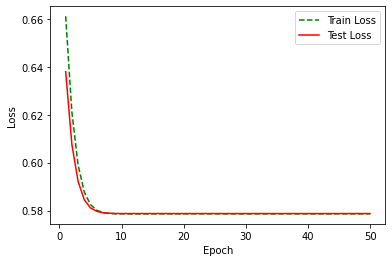

In [15]:
### Examine baseline model
import matplotlib.pyplot as plt

train_loss = hist_baseline.history['loss']
test_loss = hist_baseline.history['val_loss']

epoch_count = range(1, len(train_loss) + 1)

plt.plot(epoch_count, train_loss, 'g--')
plt.plot(epoch_count, test_loss, 'r-')
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show();

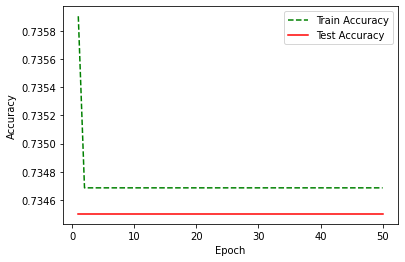

In [16]:
train_loss = hist_baseline.history['accuracy']
test_loss = hist_baseline.history['val_accuracy']

epoch_count = range(1, len(train_loss) + 1)

plt.plot(epoch_count, train_loss, 'g--')
plt.plot(epoch_count, test_loss, 'r-')
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show();

In [0]:
### Use GridSearch and CrossValidation to tune the following:

### batch_size
### training epochs
### optimizer
### learning rate (if applicable to optimizer)
### momentum (if applicable to optimizer)
### activation functions
### network weight initialization
### dropout regularization
### number of neurons in the hidden layer

#### Grid Search: batch_size

In [85]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

np.random.seed(10)

# Function to created model for KerasClassifier
def create_model():
  model = Sequential()
  model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(Dense(1, activation='sigmoid')) 
  # Complie model
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, verbose=0)

# Define grid search parameters
param_grid = {
    'batch_size': [10, 15, 20, 25, 30, 32],
    'epochs': [20]
}

# Create grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=2)
grid_result = grid.fit(X_train, y_train)

# Report results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print(f"Means: {mean}, Stdev: {stdev}, with: {param}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.3min finished


Best: 0.7346856117248535 using {'batch_size': 10, 'epochs': 20}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 10, 'epochs': 20}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 15, 'epochs': 20}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 20, 'epochs': 20}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 25, 'epochs': 20}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 30, 'epochs': 20}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 32, 'epochs': 20}


#### Grid Search: epochs

In [86]:
# Function to created model for KerasClassifier
def create_model():
  model = Sequential()
  model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(Dense(1, activation='sigmoid')) 
  # Complie model
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, verbose=0)

# Define grid search parameters
param_grid = {
    'batch_size': [10],
    'epochs': [20, 30, 40, 50]
}

# Create grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=4)
grid_result = grid.fit(X_train, y_train)

# Report results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print(f"Means: {mean}, Stdev: {stdev}, with: {param}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  6.6min finished


Best: 0.7346856117248535 using {'batch_size': 10, 'epochs': 20}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 10, 'epochs': 20}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 10, 'epochs': 30}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 10, 'epochs': 40}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 10, 'epochs': 50}


#### Grid Search: optimizer

In [88]:
# Function to created model for KerasClassifier
def create_model(optimizer='adam'):
  model = Sequential()
  model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(Dense(1, activation='sigmoid')) 
  # Complie model
  model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, verbose=0)

# Define grid search parameters
param_grid = {
    'batch_size': [10],
    'epochs': [20],
    'optimizer': ['adadelta', 'adagrad', 'adam', 'adamax', 'nadam']
}

# Create grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=4)
grid_result = grid.fit(X_train, y_train)

# Report results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print(f"Means: {mean}, Stdev: {stdev}, with: {param}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  5.0min finished


Best: 0.7346856117248535 using {'batch_size': 10, 'epochs': 20, 'optimizer': 'adadelta'}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 10, 'epochs': 20, 'optimizer': 'adadelta'}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 10, 'epochs': 20, 'optimizer': 'adagrad'}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 10, 'epochs': 20, 'optimizer': 'adam'}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 10, 'epochs': 20, 'optimizer': 'adamax'}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 10, 'epochs': 20, 'optimizer': 'nadam'}


#### Grid Search: learning_rate

In [89]:
from tensorflow.keras.optimizers import Adadelta

def create_model(lr=.01):
  opt = Adadelta(learning_rate=lr)

  model = Sequential()
  model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(Dense(1, activation='sigmoid')) 
  # Complie model
  model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, verbose=0)

# Define grid search parameters
param_grid = {
    'batch_size': [10],
    'epochs': [20],
    'lr': [.0001, .001, .01, .1, .2, .3, .4]
}

# Create grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=4)
grid_result = grid.fit(X_train, y_train)

# Report results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print(f"Means: {mean}, Stdev: {stdev}, with: {param}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  6.7min finished


Best: 0.7346856117248535 using {'batch_size': 10, 'epochs': 20, 'lr': 0.0001}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 10, 'epochs': 20, 'lr': 0.0001}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 10, 'epochs': 20, 'lr': 0.001}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 10, 'epochs': 20, 'lr': 0.01}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 10, 'epochs': 20, 'lr': 0.1}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 10, 'epochs': 20, 'lr': 0.2}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 10, 'epochs': 20, 'lr': 0.3}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'batch_size': 10, 'epochs': 20, 'lr': 0.4}


#### Grid Search: activation functions

In [90]:
def create_model(act='relu'):

  model = Sequential()
  model.add(Dense(128, activation=act, input_shape=(X_train.shape[1],)))
  model.add(Dense(1, activation='sigmoid')) 
  # Complie model
  model.compile(loss='binary_crossentropy',
                optimizer='adadelta',
                metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, verbose=0)

# Define grid search parameters
param_grid = {
    'batch_size': [10],
    'epochs': [20],
    'act': ['relu', 'swish', 'tanh']
}

# Create grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=4)
grid_result = grid.fit(X_train, y_train)

# Report results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print(f"Means: {mean}, Stdev: {stdev}, with: {param}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.0min finished


Best: 0.7346856117248535 using {'act': 'relu', 'batch_size': 10, 'epochs': 20}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'act': 'relu', 'batch_size': 10, 'epochs': 20}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'act': 'swish', 'batch_size': 10, 'epochs': 20}
Means: 0.7346856117248535, Stdev: 0.012790166718853505, with: {'act': 'tanh', 'batch_size': 10, 'epochs': 20}


#### Grid Search: initializers

In [18]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

np.random.seed(10)

#|^|^|^| Re-import due to restarting runtime

def create_model(kernel_init='random_normal', bias_init='zeros'):

  model = Sequential()
  model.add(Dense(128, 
                  activation='relu', 
                  input_shape=(X_train.shape[1],),
                  kernel_initializer=kernel_init,
                  bias_initializer=bias_init))
  
  model.add(Dense(1, activation='sigmoid')) 

  # Complie model
  model.compile(loss='binary_crossentropy',
                optimizer='adadelta',
                metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, verbose=0)

# Define grid search parameters
param_grid = {
    'batch_size': [10],
    'epochs': [20],
    'kernel_init': ['random_normal', 'uniform', 'glorot_normal'],
    'bias_init': ['zeros', 'constant', 'ones']
}

# Create grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=4)
grid_result = grid.fit(X_train, y_train)

# Report results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print(f"Means: {mean}, Stdev: {stdev}, with: {param}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 13.0min finished


Best: 0.7346855878829956 using {'batch_size': 10, 'bias_init': 'zeros', 'epochs': 20, 'kernel_init': 'random_normal'}
Means: 0.7346855878829956, Stdev: 0.014663506226523997, with: {'batch_size': 10, 'bias_init': 'zeros', 'epochs': 20, 'kernel_init': 'random_normal'}
Means: 0.7346855878829956, Stdev: 0.014663506226523997, with: {'batch_size': 10, 'bias_init': 'zeros', 'epochs': 20, 'kernel_init': 'uniform'}
Means: 0.7346855878829956, Stdev: 0.014663506226523997, with: {'batch_size': 10, 'bias_init': 'zeros', 'epochs': 20, 'kernel_init': 'glorot_normal'}
Means: 0.7346855878829956, Stdev: 0.014663506226523997, with: {'batch_size': 10, 'bias_init': 'constant', 'epochs': 20, 'kernel_init': 'random_normal'}
Means: 0.7346855878829956, Stdev: 0.014663506226523997, with: {'batch_size': 10, 'bias_init': 'constant', 'epochs': 20, 'kernel_init': 'uniform'}
Means: 0.7346855878829956, Stdev: 0.014663506226523997, with: {'batch_size': 10, 'bias_init': 'constant', 'epochs': 20, 'kernel_init': 'glorot_

#### Grid Search: neurons in hidden layer

In [19]:
def create_model(neurons=64):

  model = Sequential()
  model.add(Dense(units=neurons, 
                  activation='relu', 
                  input_shape=(X_train.shape[1],),
                  kernel_initializer="random_normal",
                  bias_initializer="zeros"))
  model.add(Dense(units=neurons, activation='relu'))
  model.add(Dense(units=neurons, activation='relu'))
  model.add(Dense(1, activation='sigmoid')) 

  # Complie model
  model.compile(loss='binary_crossentropy',
                optimizer='adadelta',
                metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, verbose=0)

# Define grid search parameters
param_grid = {
    'batch_size': [10],
    'epochs': [20],
    'neurons': [128, 64, 32, 16, 8]
}

# Create grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=4)
grid_result = grid.fit(X_train, y_train)

# Report results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print(f"Means: {mean}, Stdev: {stdev}, with: {param}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  8.0min finished


Best: 0.7346855878829956 using {'batch_size': 10, 'epochs': 20, 'neurons': 128}
Means: 0.7346855878829956, Stdev: 0.014663506226523997, with: {'batch_size': 10, 'epochs': 20, 'neurons': 128}
Means: 0.7346855878829956, Stdev: 0.014663506226523997, with: {'batch_size': 10, 'epochs': 20, 'neurons': 64}
Means: 0.7346855878829956, Stdev: 0.014663506226523997, with: {'batch_size': 10, 'epochs': 20, 'neurons': 32}
Means: 0.7346855878829956, Stdev: 0.014663506226523997, with: {'batch_size': 10, 'epochs': 20, 'neurons': 16}
Means: 0.7346855878829956, Stdev: 0.014663506226523997, with: {'batch_size': 10, 'epochs': 20, 'neurons': 8}


## Stretch Goals:

- Try to implement Random Search Hyperparameter Tuning on this dataset
- Try to implement Bayesian Optimiation tuning on this dataset using hyperas or hyperopt (if you're brave)
- Practice hyperparameter tuning other datasets that we have looked at. How high can you get MNIST? Above 99%?
- Study for the Sprint Challenge
 - Can you implement both perceptron and MLP models from scratch with forward and backpropagation?
 - Can you implement both perceptron and MLP models in keras and tune their hyperparameters with cross validation?